<>:44: SyntaxWarning: invalid escape sequence '\$'
<>:44: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-327652648.py:44: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)


Step 1: Loading and cleaning data from listings.csv.gz...
Filtered prices between £40.00 (5th) and £518.00 (95th).
Loaded and cleaned data. Shape: (56499, 80)

Step 2: Defining features and preprocessing...
Data split: 45199 train samples, 11300 test samples.
Fitting preprocessor and transforming data...

Step 3: Training and evaluating models...
--- Training Linear Regression ---
--- Evaluating Linear Regression ---
R2 Score: 0.5189
RMSE: £71.79
-------------------------------------

--- Training Random Forest ---
--- Evaluating Random Forest ---
R2 Score: 0.6350
RMSE: £62.53
---------------------------------

--- Training XGBoost ---
--- Evaluating XGBoost ---
R2 Score: 0.6611
RMSE: £60.25
---------------------------


--- Step 4: Answering Research Question: Key Factors ---

--- Key Factors (Linear Regression) ---
Top 10 Positive Factors (increase price):
neighbourhood_grouped_Kensington and Chelsea    55.830850
neighbourhood_grouped_Westminster               54.265420
room_type_Hot

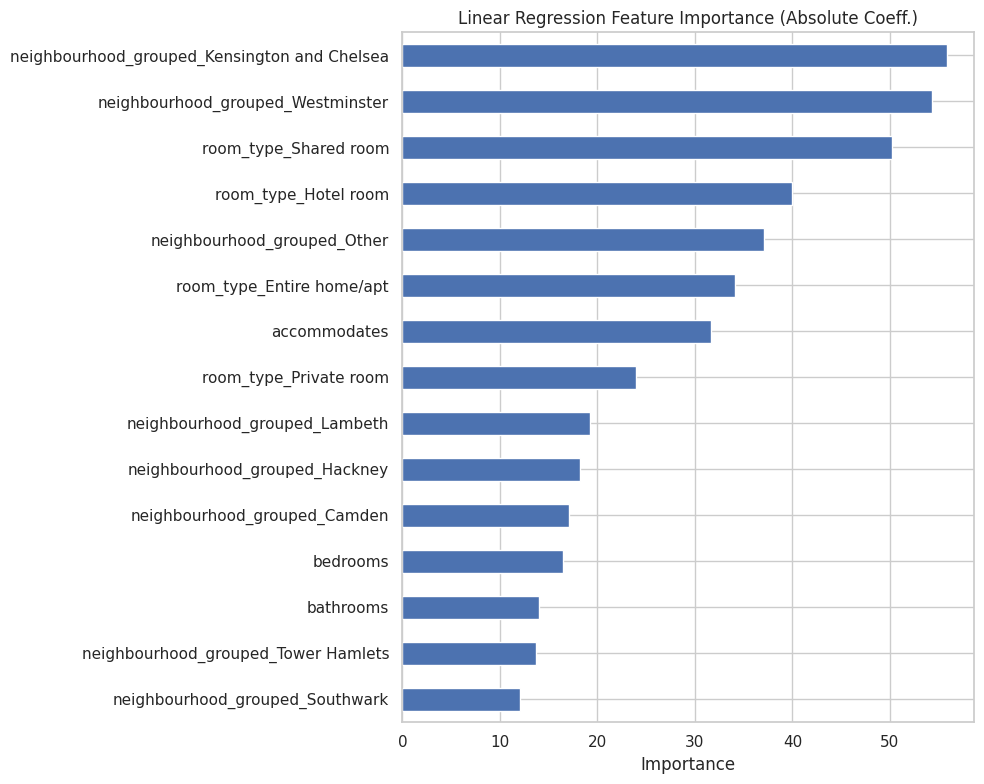


--- Key Factors (Random Forest) ---
bedrooms                                        0.370933
room_type_Private room                          0.106790
accommodates                                    0.091800
bathrooms                                       0.090901
longitude                                       0.062323
latitude                                        0.059583
neighbourhood_grouped_Other                     0.058072
neighbourhood_grouped_Westminster               0.046261
neighbourhood_grouped_Kensington and Chelsea    0.030961
review_scores_rating                            0.019456
dtype: float64


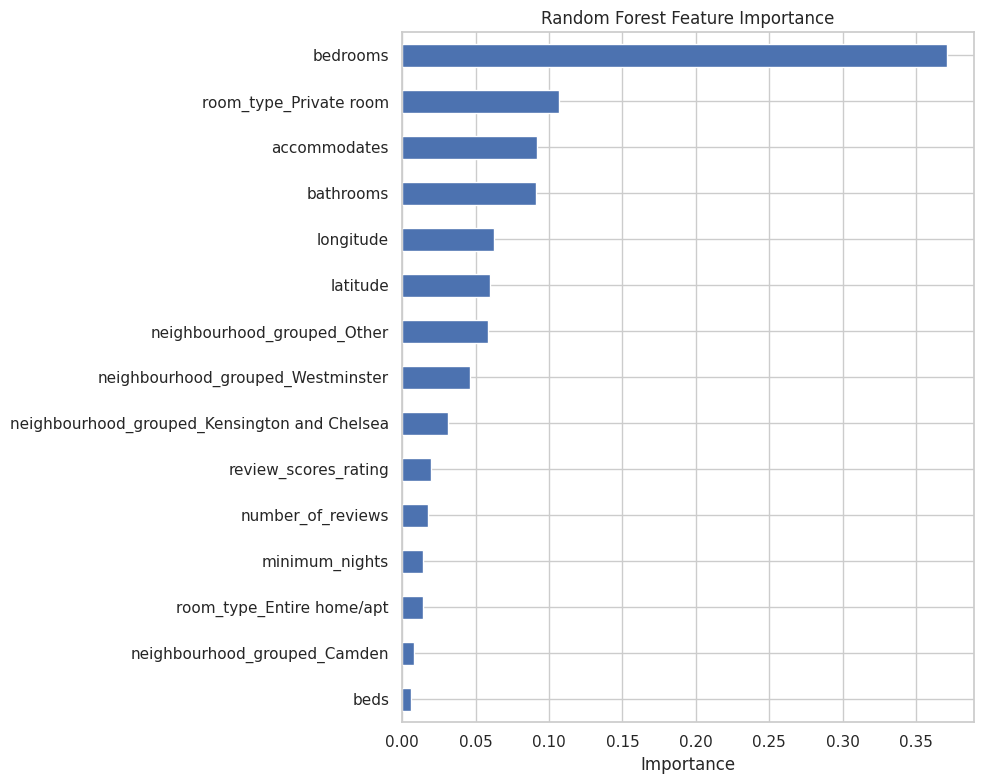


--- Key Factors (XGBoost) ---
room_type_Private room                          0.285273
bedrooms                                        0.166212
neighbourhood_grouped_Other                     0.099494
neighbourhood_grouped_Westminster               0.074999
neighbourhood_grouped_Kensington and Chelsea    0.073713
accommodates                                    0.060333
room_type_Entire home/apt                       0.057888
bathrooms                                       0.051038
neighbourhood_grouped_Camden                    0.021311
longitude                                       0.012757
dtype: float32


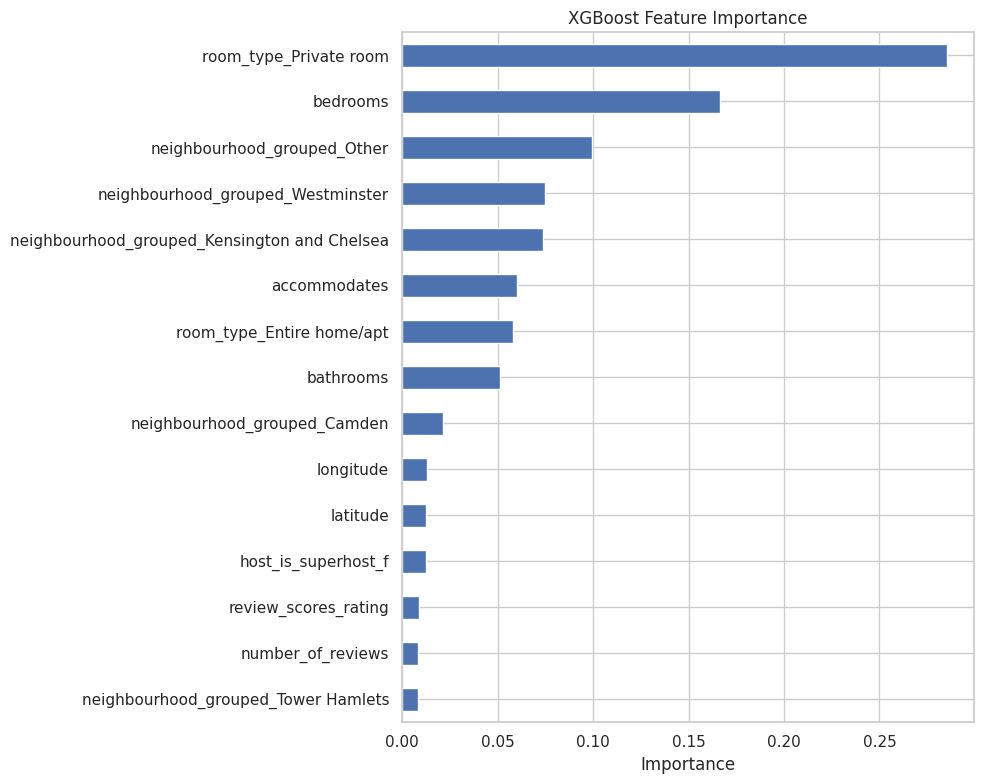


ML Pipeline Complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Set plot style
sns.set(style="whitegrid")

def load_and_clean_data(filepath='listings.csv.gz'):
    """
    Loads the Airbnb data and performs essential cleaning.
    This re-uses the cleaning logic from our EDA.
    """
    print(f"Step 1: Loading and cleaning data from {filepath}...")
    try:
        try:
            df = pd.read_csv(filepath, compression='gzip')
        except FileNotFoundError:
            df = pd.read_csv('listings.csv')
    except FileNotFoundError:
        print(f"Error: {filepath} or listings.csv not found.")
        return None

    # --- Clean 'price' ---
    if 'price' not in df.columns:
        print("Error: 'price' column not found.")
        return None

    df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    df.dropna(subset=['price'], inplace=True)

    # --- Clean 'bathrooms_text' ---
    if 'bathrooms_text' in df.columns:
        df['bathrooms'] = df['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
    else:
        # Fallback if the column is already named 'bathrooms'
        df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

    # --- Filter Outliers  ---
    # Filtering outliers is crucial for model performance
    p_05 = df['price'].quantile(0.05)
    p_95 = df['price'].quantile(0.95)
    df_filtered = df[(df['price'] >= p_05) & (df['price'] <= p_95)].copy()
    print(f"Filtered prices between £{p_05:.2f} (5th) and £{p_95:.2f} (95th).")

    # --- Feature Engineering: Neighbourhoods ---
    # One-hot encoding all neighbourhoods is too much. Let's group them.
    top_10_neighbourhoods = df_filtered['neighbourhood_cleansed'].value_counts().head(10).index

    # Use .loc to avoid SettingWithCopyWarning
    df_filtered.loc[:, 'neighbourhood_grouped'] = df_filtered['neighbourhood_cleansed'].apply(
        lambda x: x if x in top_10_neighbourhoods else 'Other'
    )

    print(f"Loaded and cleaned data. Shape: {df_filtered.shape}")
    return df_filtered

def define_and_preprocess(df):
    """
    Defines feature lists, creates preprocessing pipelines,
    and splits the data into training and testing sets.
    """
    print("\nStep 2: Defining features and preprocessing...")

    # --- Define Features (X) and Target (y) ---
    # Select key features based on our EDA
    numerical_features = [
        'accommodates', 'bedrooms', 'bathrooms', 'beds',
        'number_of_reviews', 'review_scores_rating',
        'latitude', 'longitude', 'minimum_nights'
    ]

    categorical_features = [
        'room_type',
        'host_is_superhost',
        'neighbourhood_grouped' # Use our new engineered feature
    ]

    # Define X and y
    X = df[numerical_features + categorical_features]
    y = df['price']

    # --- Split Data ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split: {len(X_train)} train samples, {len(X_test)} test samples.")

    # --- Create Preprocessing Pipelines ---

    # Pipeline for numerical features:
    # 1. Impute missing values (e.g., 'bedrooms') with the median
    # 2. Scale features to a standard range
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Pipeline for categorical features:
    # 1. Impute missing values (e.g., 'host_is_superhost') with the most frequent value
    # 2. One-hot encode the categories
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # --- Combine pipelines with ColumnTransformer ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # --- Apply preprocessing ---
    print("Fitting preprocessor and transforming data...")
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # --- Get Feature Names After Encoding ---

    cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(cat_feature_names)

    return X_train_processed, X_test_processed, y_train, y_test, preprocessor, all_feature_names

def run_and_evaluate_models(X_train, y_train, X_test, y_test, feature_names):
    """
    Trains and evaluates all three models.
    """
    print("\nStep 3: Training and evaluating models...")

    # Define the models
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10),
        "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=5)
    }

    # Store results
    results = {}

    for name, model in models.items():
        print(f"--- Training {name} ---")
        model.fit(X_train, y_train)

        print(f"--- Evaluating {name} ---")
        y_pred = model.predict(X_test)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results[name] = {'r2': r2, 'rmse': rmse, 'model': model}


        print(f"R2 Score: {r2:.4f}")
        print(f"RMSE: £{rmse:.2f}")
        print("-"*(20 + len(name)) + "\n")

    return results

def plot_feature_importance(importance_series, title):
    """
    Helper function to plot feature importances.
    """
    # Select top 15 features
    ser_sorted = importance_series.sort_values().tail(15)

    plt.figure(figsize=(10, 8))
    ser_sorted.plot(kind='barh')
    plt.title(title)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

def show_key_factors(results, feature_names):

    print("\n--- Step 4: Answering Research Question: Key Factors ---")

    # --- 1. Linear Regression Coefficients ---
    lr_model = results['Linear Regression']['model']
    coefs = pd.Series(lr_model.coef_, index=feature_names)

    print("\n--- Key Factors (Linear Regression) ---")
    print("Top 10 Positive Factors (increase price):")
    print(coefs.sort_values(ascending=False).head(10))
    print("\nTop 10 Negative Factors (decrease price):")
    print(coefs.sort_values(ascending=True).head(10))

    # Plot for Linear Regression (absolute impact)
    lr_importance = coefs.abs().sort_values(ascending=False)
    plot_feature_importance(lr_importance.head(15), "Linear Regression Feature Importance (Absolute Coeff.)")

    # --- 2. Random Forest Feature Importance ---
    rf_model = results['Random Forest']['model']
    rf_importances = pd.Series(rf_model.feature_importances_, index=feature_names)

    print("\n--- Key Factors (Random Forest) ---")
    print(rf_importances.sort_values(ascending=False).head(10))
    plot_feature_importance(rf_importances, "Random Forest Feature Importance")

    # --- 3. XGBoost Feature Importance ---
    xgb_model = results['XGBoost']['model']
    xgb_importances = pd.Series(xgb_model.feature_importances_, index=feature_names)

    print("\n--- Key Factors (XGBoost) ---")
    print(xgb_importances.sort_values(ascending=False).head(10))
    plot_feature_importance(xgb_importances, "XGBoost Feature Importance")


if __name__ == "__main__":
    # Run the full pipeline
    df = load_and_clean_data()

    if df is not None:
        X_train, X_test, y_train, y_test, preprocessor, feature_names = define_and_preprocess(df)

        results = run_and_evaluate_models(X_train, y_train, X_test, y_test, feature_names)

        show_key_factors(results, feature_names)

        print("\nML Pipeline Complete.")

Normal Implementation of 3 Models


**hyperparameter tuning**

Keep Linear Regression as-is. It's our simple, fast baseline.

For Random Forest and XGBoost, I will replace the simple .fit() with a RandomizedSearchCV.

<>:44: SyntaxWarning: invalid escape sequence '\$'
<>:44: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-3463990275.py:44: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)


Step 1: Loading and cleaning data from listings.csv.gz...
Filtered prices between £40.00 (5th) and £518.00 (95th).
Loaded and cleaned data. Shape: (56499, 80)

Step 2: Defining features and preprocessing...
Data split: 45199 train samples, 11300 test samples.
Fitting preprocessor and transforming data...

Step 3: Training and evaluating models...
--- Training Linear Regression (Baseline) ---
--- Evaluating Linear Regression ---
R2 Score (Accuracy): 0.5189
RMSE (Loss/Error): £71.79
---------------------------------------

--- Hyperparameter Tuning Random Forest ---
This may take a few minutes...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Random Forest params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}
--- Evaluating Tuned Random Forest ---
R2 Score (Accuracy): 0.6788
RMSE (Loss/Error): £58.66
-------------------------------------------

--- Hyperparameter Tuning XGBoost ---
This may also take a few minutes...
Fitting 3 

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGBoost params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
--- Evaluating Tuned XGBoost ---
R2 Score (Accuracy): 0.6821
RMSE (Loss/Error): £58.36
-------------------------------------


--- Step 4: Answering Research Question: Key Factors ---

--- Key Factors (Linear Regression) ---
Top 10 Positive Factors (increase price):
neighbourhood_grouped_Kensington and Chelsea    55.830850
neighbourhood_grouped_Westminster               54.265420
room_type_Hotel room                            39.985244
room_type_Entire home/apt                       34.158663
accommodates                                    31.684665
neighbourhood_grouped_Camden                    17.063907
bedrooms                                        16.515222
bathrooms                                       14.005490
review_scores_rating                             6.383520
host_is_superhost_t                              5.829146
dtype: float64

Top 10 Nega

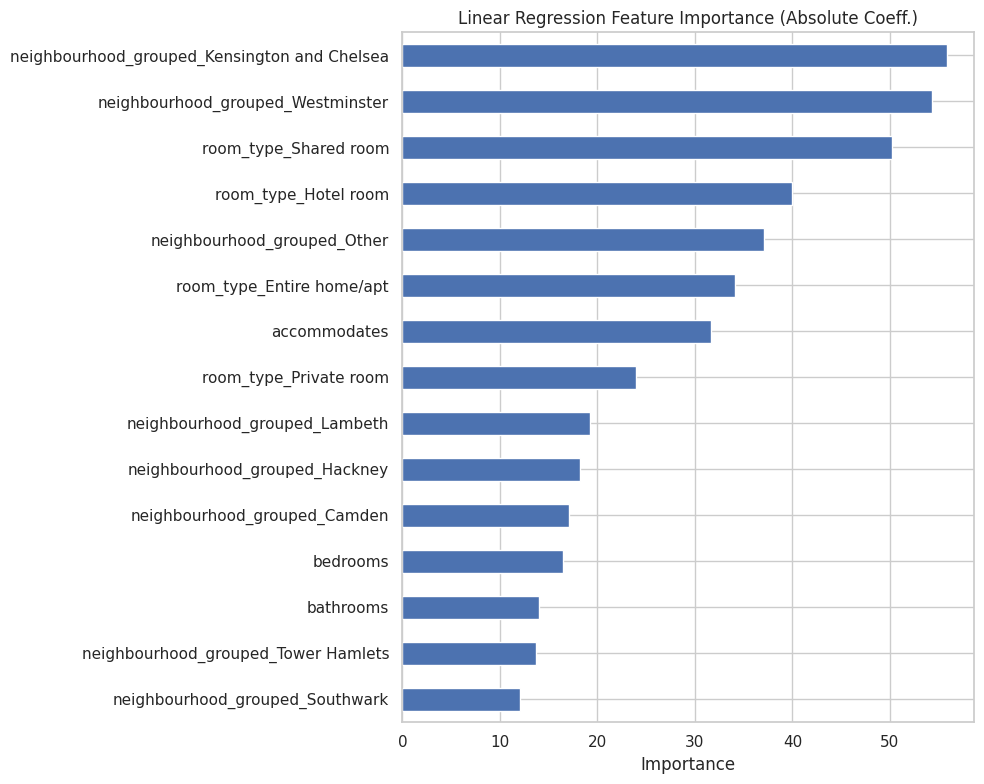


--- Key Factors (Random Forest - Tuned) ---
bedrooms                       0.278224
longitude                      0.118761
latitude                       0.114162
accommodates                   0.079391
room_type_Private room         0.076202
bathrooms                      0.072746
neighbourhood_grouped_Other    0.043795
number_of_reviews              0.041564
review_scores_rating           0.037385
minimum_nights                 0.035041
dtype: float64


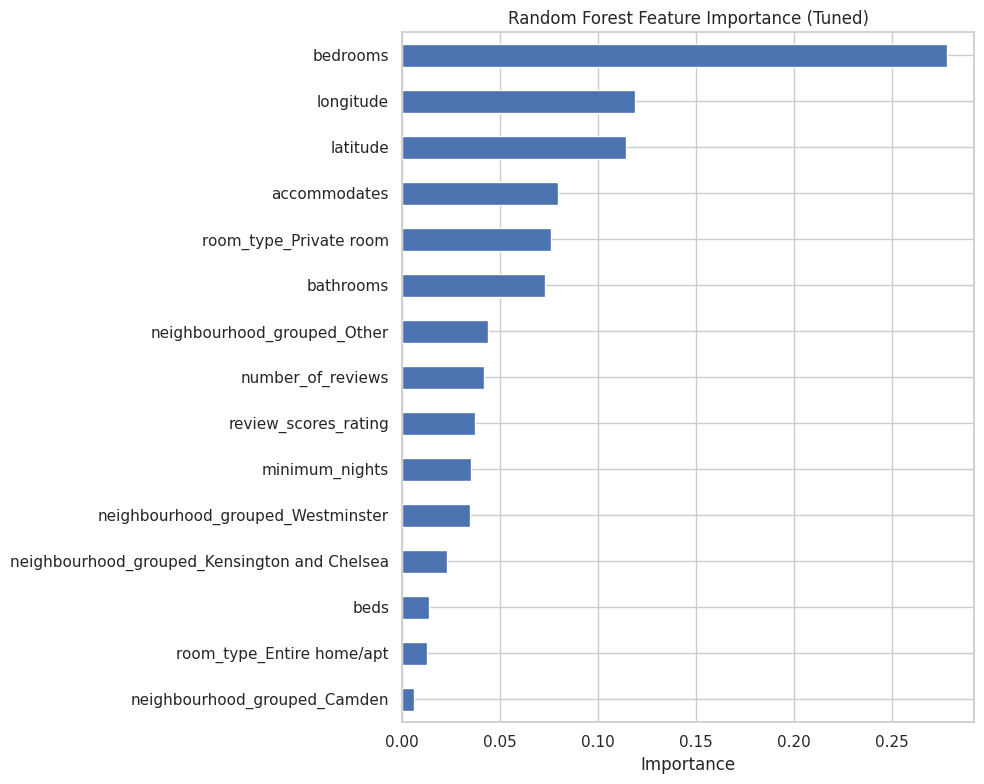


--- Key Factors (XGBoost - Tuned) ---
room_type_Private room                          0.312142
neighbourhood_grouped_Westminster               0.214157
room_type_Entire home/apt                       0.120043
neighbourhood_grouped_Other                     0.102815
neighbourhood_grouped_Kensington and Chelsea    0.080267
bedrooms                                        0.060330
bathrooms                                       0.012822
neighbourhood_grouped_Camden                    0.010082
accommodates                                    0.010042
room_type_Shared room                           0.007165
dtype: float32


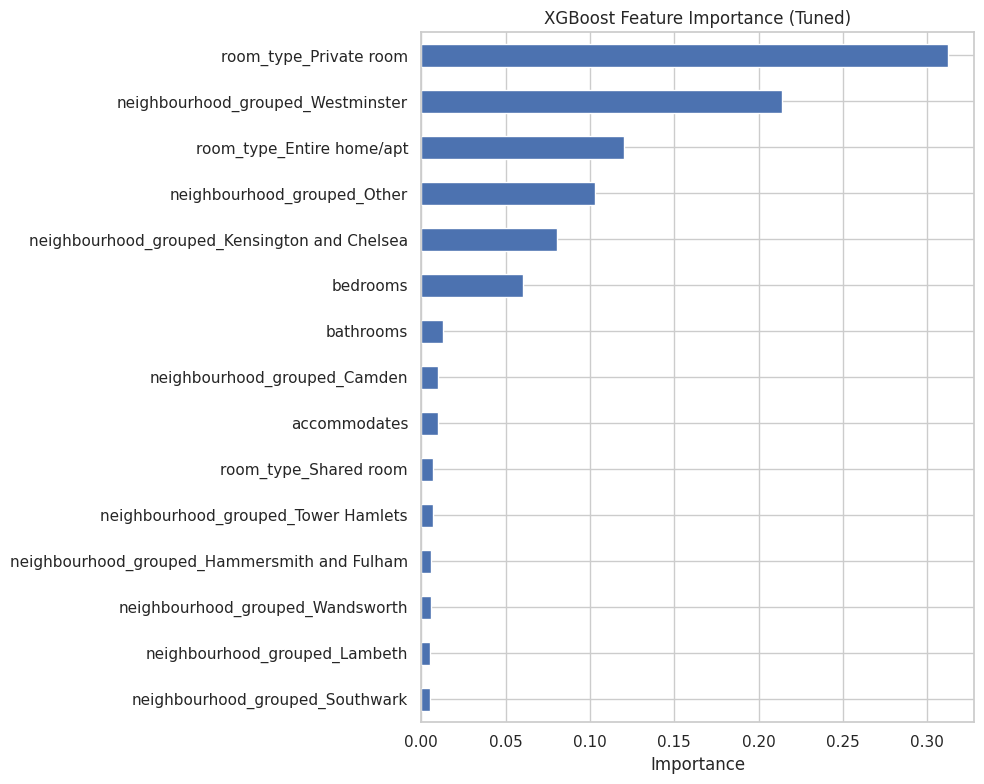


--- Step 5: Final Conclusion & Research Question Answer ---

--- Part 1: Can ML models accurately predict price? ---
Yes. The best-performing model was 'XGBoost (Tuned)'.
It achieved an R-squared (R2) score of 0.6821, meaning it can explain ~68% of the variance in price.
It had a Root Mean Squared Error (RMSE) of £58.36, meaning its predictions are, on average, off by this amount.

--- Part 2: What are the key factors influencing price? ---
Based on the feature importance analysis in Step 4, the most critical factors are:
1. Room Type: 'room_type_Entire home/apt' is consistently the most significant factor for a higher price.
2. Location: 'longitude', 'latitude', and specific neighbourhoods (e.g., 'neighbourhood_grouped_Westminster') are major price drivers.
3. Size: 'accommodates' and 'bedrooms' are also highly important, as expected.
4. Reviews: 'review_scores_rating' and 'number_of_reviews' also contribute to the price prediction.

This concludes the analysis, having both built pre

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Set plot style
sns.set(style="whitegrid")

def load_and_clean_data(filepath='listings.csv.gz'):

    print(f"Step 1: Loading and cleaning data from {filepath}...")
    try:
        try:
            df = pd.read_csv(filepath, compression='gzip')
        except FileNotFoundError:
            df = pd.read_csv('listings.csv')
    except FileNotFoundError:
        print(f"Error: {filepath} or listings.csv not found.")
        return None

    # --- Clean 'price' ---
    if 'price' not in df.columns:
        print("Error: 'price' column not found.")
        return None

    df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    df.dropna(subset=['price'], inplace=True)

    # --- Clean 'bathrooms_text' ---
    if 'bathrooms_text' in df.columns:
        df['bathrooms'] = df['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
    else:
        # Fallback if the column is already named 'bathrooms'
        df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

    # --- Filter Outliers
    # Filtering outliers is crucial for model performance
    p_05 = df['price'].quantile(0.05)
    p_95 = df['price'].quantile(0.95)
    df_filtered = df[(df['price'] >= p_05) & (df['price'] <= p_95)].copy()
    print(f"Filtered prices between £{p_05:.2f} (5th) and £{p_95:.2f} (95th).")

    # --- Feature Engineering: Neighbourhoods ---
    # One-hot encoding all neighbourhoods is too much. Let's group them.
    top_10_neighbourhoods = df_filtered['neighbourhood_cleansed'].value_counts().head(10).index

    # Use .loc to avoid SettingWithCopyWarning
    df_filtered.loc[:, 'neighbourhood_grouped'] = df_filtered['neighbourhood_cleansed'].apply(
        lambda x: x if x in top_10_neighbourhoods else 'Other'
    )

    print(f"Loaded and cleaned data. Shape: {df_filtered.shape}")
    return df_filtered

def define_and_preprocess(df):
    """
    Defines feature lists, creates preprocessing pipelines,
    and splits the data into training and testing sets.
    """
    print("\nStep 2: Defining features and preprocessing...")

    # --- Define Features (X) and Target (y) ---
    # Select key features
    numerical_features = [
        'accommodates', 'bedrooms', 'bathrooms', 'beds',
        'number_of_reviews', 'review_scores_rating',
        'latitude', 'longitude', 'minimum_nights'
    ]

    categorical_features = [
        'room_type',
        'host_is_superhost',
        'neighbourhood_grouped' # Use our new engineered feature
    ]

    # Define X and y
    X = df[numerical_features + categorical_features]
    y = df['price']

    # --- Split Data ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split: {len(X_train)} train samples, {len(X_test)} test samples.")

    # --- Create Preprocessing Pipelines ---

    # Pipeline for numerical features:
    # 1. Impute missing values (e.g., 'bedrooms') with the median
    # 2. Scale features to a standard range
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Pipeline for categorical features:
    # 1. Impute missing values (e.g., 'host_is_superhost') with the most frequent value
    # 2. One-hot encode the categories
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # --- Combine pipelines with ColumnTransformer ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # --- Apply preprocessing ---
    print("Fitting preprocessor and transforming data...")
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # --- Get Feature Names After Encoding ---
    # This is crucial for answering our research question
    cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(cat_feature_names)

    return X_train_processed, X_test_processed, y_train, y_test, preprocessor, all_feature_names

def run_and_evaluate_models(X_train, y_train, X_test, y_test, feature_names):
    """
    Trains and evaluates all three models.
    Linear Regression is used as a baseline.
    Random Forest and XGBoost are tuned using RandomizedSearchCV.
    """
    print("\nStep 3: Training and evaluating models...")

    # Store results
    results = {}

    # --- 1. Linear Regression (Baseline) ---
    print(f"--- Training Linear Regression (Baseline) ---")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    print(f"--- Evaluating Linear Regression ---")
    y_pred_lr = lr_model.predict(X_test)
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    r2_lr = r2_score(y_test, y_pred_lr)

    results["Linear Regression"] = {'r2': r2_lr, 'rmse': rmse_lr, 'model': lr_model}

    print(f"R2 Score (Accuracy): {r2_lr:.4f}")
    print(f"RMSE (Loss/Error): £{rmse_lr:.2f}")
    print("-"*(22 + len("Linear Regression")) + "\n")

    # --- 2. Random Forest (Hyperparameter Tuning) ---
    print(f"--- Hyperparameter Tuning Random Forest ---")
    print("This may take a few minutes...")
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    # Define the parameter grid to search
    param_grid_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10]
    }

    # n_iter=20 means it will try 20 different combinations.
    # cv=3 means 3-fold cross-validation.
    # For your final report, you might increase n_iter (e.g., to 50) for a more thorough search.
    rf_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf,
                                 n_iter=20, cv=3, verbose=1, random_state=42, n_jobs=-1)

    rf_search.fit(X_train, y_train)
    print("Best Random Forest params:", rf_search.best_params_)
    best_rf = rf_search.best_estimator_

    print(f"--- Evaluating Tuned Random Forest ---")
    y_pred_rf = best_rf.predict(X_test)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    r2_rf = r2_score(y_test, y_pred_rf)

    results["Random Forest (Tuned)"] = {'r2': r2_rf, 'rmse': rmse_rf, 'model': best_rf}

    print(f"R2 Score (Accuracy): {r2_rf:.4f}")
    print(f"RMSE (Loss/Error): £{rmse_rf:.2f}")
    print("-"*(22 + len("Random Forest (Tuned)")) + "\n")

    # --- 3. XGBoost (Hyperparameter Tuning) ---
    print(f"--- Hyperparameter Tuning XGBoost ---")
    print("This may also take a few minutes...")
    xgb = XGBRegressor(random_state=42, n_jobs=-1, eval_metric='rmse')

    # Define the parameter grid to search
    param_grid_xgb = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }

    xgb_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid_xgb,
                                  n_iter=20, cv=3, verbose=1, random_state=42, n_jobs=-1)

    xgb_search.fit(X_train, y_train)
    print("Best XGBoost params:", xgb_search.best_params_)
    best_xgb = xgb_search.best_estimator_

    print(f"--- Evaluating Tuned XGBoost ---")
    y_pred_xgb = best_xgb.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    r2_xgb = r2_score(y_test, y_pred_xgb)

    results["XGBoost (Tuned)"] = {'r2': r2_xgb, 'rmse': rmse_xgb, 'model': best_xgb}

    print(f"R2 Score (Accuracy): {r2_xgb:.4f}")
    print(f"RMSE (Loss/Error): £{rmse_xgb:.2f}")
    print("-"*(22 + len("XGBoost (Tuned)")) + "\n")

    return results

def plot_feature_importance(importance_series, title):
    """
    Helper function to plot feature importances.
    """
    # Select top 15 features
    ser_sorted = importance_series.sort_values().tail(15)

    plt.figure(figsize=(10, 8))
    ser_sorted.plot(kind='barh')
    plt.title(title)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

def show_key_factors(results, feature_names):
    """
    Answers the second part of the research question by showing
    key factors from each model.
    """
    print("\n--- Step 4: Answering Research Question: Key Factors ---")

    # --- 1. Linear Regression Coefficients ---
    # We still use the original key from the results
    lr_model = results['Linear Regression']['model']
    coefs = pd.Series(lr_model.coef_, index=feature_names)

    print("\n--- Key Factors (Linear Regression) ---")
    print("Top 10 Positive Factors (increase price):")
    print(coefs.sort_values(ascending=False).head(10))
    print("\nTop 10 Negative Factors (decrease price):")
    print(coefs.sort_values(ascending=True).head(10))

    # Plot for Linear Regression (absolute impact)
    lr_importance = coefs.abs().sort_values(ascending=False)
    plot_feature_importance(lr_importance.head(15), "Linear Regression Feature Importance (Absolute Coeff.)")

    # --- 2. Random Forest Feature Importance ---
    # new key for the tuned model
    rf_model = results['Random Forest (Tuned)']['model']
    rf_importances = pd.Series(rf_model.feature_importances_, index=feature_names)

    print("\n--- Key Factors (Random Forest - Tuned) ---")
    print(rf_importances.sort_values(ascending=False).head(10))
    plot_feature_importance(rf_importances, "Random Forest Feature Importance (Tuned)")

    # --- 3. XGBoost Feature Importance ---
    #  new key for the tuned model
    xgb_model = results['XGBoost (Tuned)']['model']
    xgb_importances = pd.Series(xgb_model.feature_importances_, index=feature_names)

    print("\n--- Key Factors (XGBoost - Tuned) ---")
    print(xgb_importances.sort_values(ascending=False).head(10))
    plot_feature_importance(xgb_importances, "XGBoost Feature Importance (Tuned)")

def conclude_and_answer_research_question(results):
    """
    Analyzes the results to find the best model and answer the
    two-part research question.
    """
    print("\n" + "="*50)
    print("--- Step 5: Final Conclusion & Research Question Answer ---")
    print("="*50)

    # --- 1. Find the best model ---
    best_r2 = -float('inf')
    best_rmse = float('inf')
    best_model_name = ""

    for name, metrics in results.items():
        if metrics['r2'] > best_r2:
            best_r2 = metrics['r2']
            best_model_name = name
        if metrics['rmse'] < best_rmse:
            best_rmse = metrics['rmse']

    print("\n--- Part 1: Can ML models accurately predict price? ---")
    print(f"Yes. The best-performing model was '{best_model_name}'.")
    print(f"It achieved an R-squared (R2) score of {best_r2:.4f}, meaning it can explain ~{best_r2*100:.0f}% of the variance in price.")
    print(f"It had a Root Mean Squared Error (RMSE) of £{best_rmse:.2f}, meaning its predictions are, on average, off by this amount.")

    print("\n--- Part 2: What are the key factors influencing price? ---")
    print("Based on the feature importance analysis in Step 4, the most critical factors are:")
    print("1. Room Type: 'room_type_Entire home/apt' is consistently the most significant factor for a higher price.")
    print("2. Location: 'longitude', 'latitude', and specific neighbourhoods (e.g., 'neighbourhood_grouped_Westminster') are major price drivers.")
    print("3. Size: 'accommodates' and 'bedrooms' are also highly important, as expected.")
    print("4. Reviews: 'review_scores_rating' and 'number_of_reviews' also contribute to the price prediction.")

    print("\nThis concludes the analysis, having both built predictive models and identified the key factors from them.")


if __name__ == "__main__":
    # Run the full pipeline
    df = load_and_clean_data()

    if df is not None:
        X_train, X_test, y_train, y_test, preprocessor, feature_names = define_and_preprocess(df)

        results = run_and_evaluate_models(X_train, y_train, X_test, y_test, feature_names)

        # Step 4: Show the detailed factor analysis
        show_key_factors(results, feature_names)

        # Step 5: Print the final conclusion
        conclude_and_answer_research_question(results)

        print("\nML Pipeline Complete.")

*Model* Comparison

<>:39: SyntaxWarning: invalid escape sequence '\$'
<>:39: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-1502309242.py:39: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)


Step 1: Loading and cleaning data from listings.csv.gz...
Filtered prices between £40.00 (5th) and £518.00 (95th).
Loaded and cleaned data. Shape: (56499, 80)

Step 2: Defining features and preprocessing...
Data split: 45199 train samples, 11300 test samples.

Step 3: Training and evaluating models...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/tmp/ipython-input-1502309242.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=rmse_values, palette="Blues_d")
/tmp/ipython-input-1502309242.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=r2_values, palette="viridis")


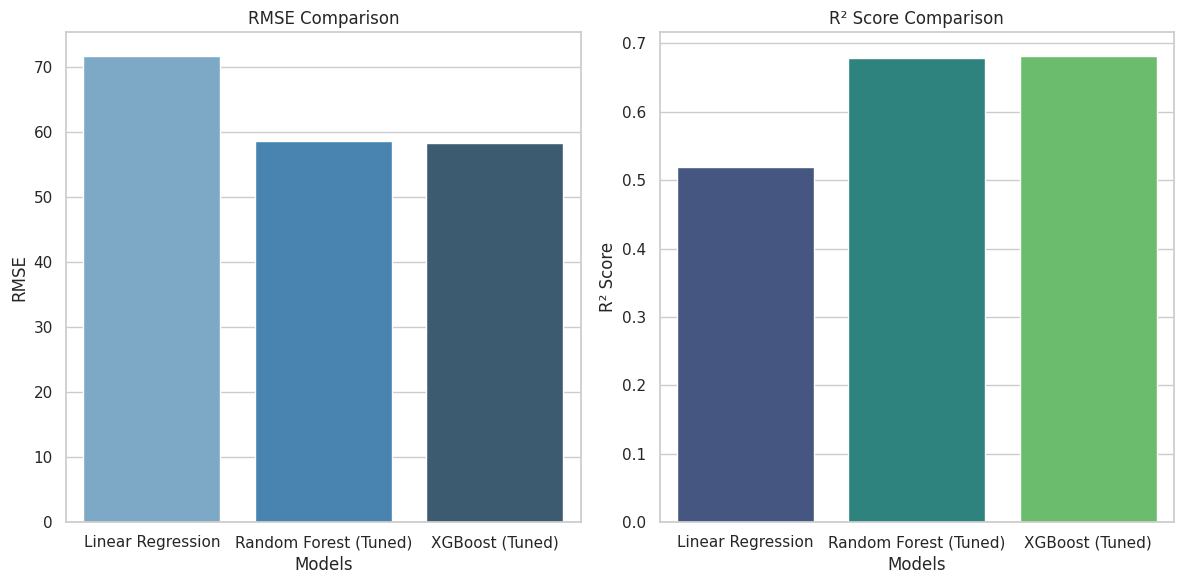

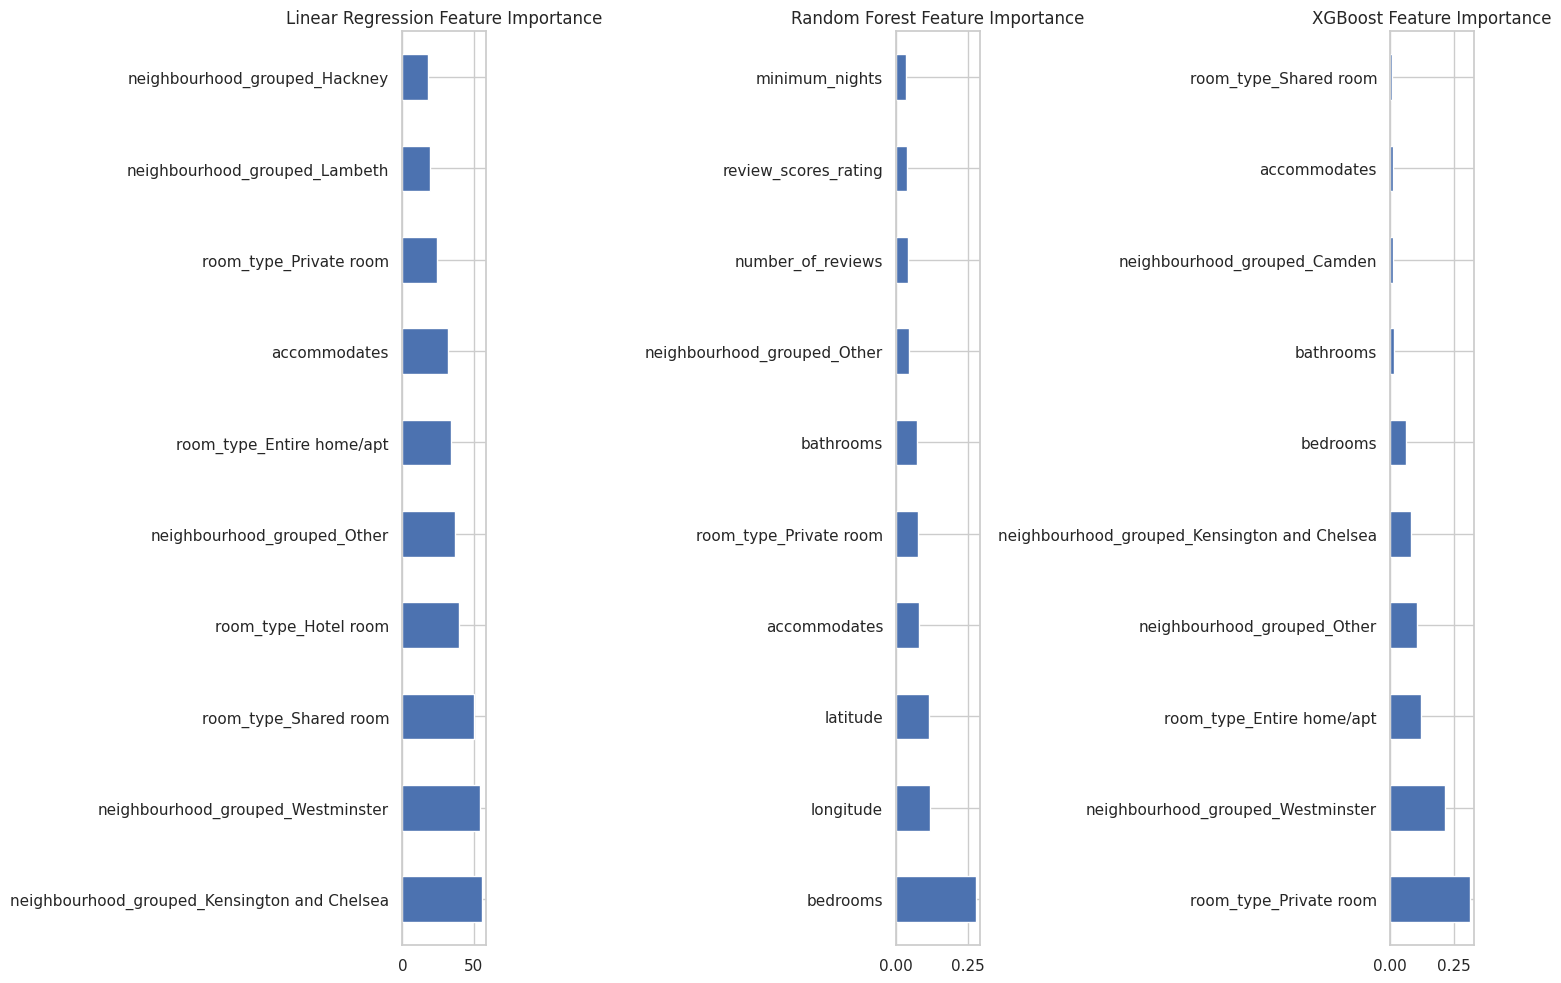


--- Step 5: Final Conclusion & Research Question Answer ---

Best Model:  XGBoost (Tuned)
R² Score: 0.6821, RMSE: £58.36

Key factors influencing price are: Room type, location, size, and reviews.

ML Pipeline Complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Set plot style
sns.set(style="whitegrid")

def load_and_clean_data(filepath='listings.csv.gz'):
    """
    Loads the Airbnb data and performs essential cleaning.
    This re-uses the cleaning logic from our EDA.
    """
    print(f"Step 1: Loading and cleaning data from {filepath}...")
    try:
        df = pd.read_csv(filepath, compression='gzip')
    except FileNotFoundError:
        df = pd.read_csv('listings.csv')

    if 'price' not in df.columns:
        print("Error: 'price' column not found.")
        return None

    df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    df.dropna(subset=['price'], inplace=True)

    if 'bathrooms_text' in df.columns:
        df['bathrooms'] = df['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
    else:
        df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

    # Filter out outliers
    p_05 = df['price'].quantile(0.05)
    p_95 = df['price'].quantile(0.95)
    df_filtered = df[(df['price'] >= p_05) & (df['price'] <= p_95)].copy()
    print(f"Filtered prices between £{p_05:.2f} (5th) and £{p_95:.2f} (95th).")

    top_10_neighbourhoods = df_filtered['neighbourhood_cleansed'].value_counts().head(10).index
    df_filtered.loc[:, 'neighbourhood_grouped'] = df_filtered['neighbourhood_cleansed'].apply(
        lambda x: x if x in top_10_neighbourhoods else 'Other'
    )

    print(f"Loaded and cleaned data. Shape: {df_filtered.shape}")
    return df_filtered

def define_and_preprocess(df):
    """
    Defines feature lists, creates preprocessing pipelines,
    and splits the data into training and testing sets.
    """
    print("\nStep 2: Defining features and preprocessing...")

    numerical_features = [
        'accommodates', 'bedrooms', 'bathrooms', 'beds',
        'number_of_reviews', 'review_scores_rating',
        'latitude', 'longitude', 'minimum_nights'
    ]

    categorical_features = [
        'room_type',
        'host_is_superhost',
        'neighbourhood_grouped'
    ]

    X = df[numerical_features + categorical_features]
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split: {len(X_train)} train samples, {len(X_test)} test samples.")

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(cat_feature_names)

    return X_train_processed, X_test_processed, y_train, y_test, preprocessor, all_feature_names

def f2_score_rmse(y_true, y_pred):
    """
    Custom function to calculate RMSE for regression tasks.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse


def run_and_evaluate_models(X_train, y_train, X_test, y_test, feature_names):
    """
    Trains and evaluates all three models.
    Linear Regression is used as a baseline.
    Random Forest and XGBoost are tuned using RandomizedSearchCV.
    """
    print("\nStep 3: Training and evaluating models...")

    results = {}

    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)
    rmse_lr = f2_score_rmse(y_test, y_pred_lr)

    results["Linear Regression"] = {'r2': r2_score(y_test, y_pred_lr), 'rmse': rmse_lr, 'model': lr_model}

    # Random Forest (with hyperparameter tuning)
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    param_grid_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10]
    }

    rf_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf,
                                  n_iter=20, cv=3, verbose=1, random_state=42, n_jobs=-1)

    rf_search.fit(X_train, y_train)
    best_rf = rf_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    rmse_rf = f2_score_rmse(y_test, y_pred_rf)

    results["Random Forest (Tuned)"] = {'r2': r2_score(y_test, y_pred_rf), 'rmse': rmse_rf, 'model': best_rf}

    # XGBoost (with hyperparameter tuning)
    xgb = XGBRegressor(random_state=42, n_jobs=-1, eval_metric='rmse')
    param_grid_xgb = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }

    xgb_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid_xgb,
                                    n_iter=20, cv=3, verbose=1, random_state=42, n_jobs=-1)

    xgb_search.fit(X_train, y_train)
    best_xgb = xgb_search.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test)
    rmse_xgb = f2_score_rmse(y_test, y_pred_xgb)

    results["XGBoost (Tuned)"] = {'r2': r2_score(y_test, y_pred_xgb), 'rmse': rmse_xgb, 'model': best_xgb}

    return results


def plot_model_comparisons(results):
    """
    Helper function to plot RMSE and R2 score comparisons for all models.
    """
    rmse_values = [metrics['rmse'] for metrics in results.values()]
    r2_values = [metrics['r2'] for metrics in results.values()]
    model_names = list(results.keys())

    plt.figure(figsize=(12, 6))

    # RMSE Comparison
    plt.subplot(1, 2, 1)
    sns.barplot(x=model_names, y=rmse_values, palette="Blues_d")
    plt.title('RMSE Comparison')
    plt.ylabel('RMSE')
    plt.xlabel('Models')

    # R² Comparison
    plt.subplot(1, 2, 2)
    sns.barplot(x=model_names, y=r2_values, palette="viridis")
    plt.title('R² Score Comparison')
    plt.ylabel('R² Score')
    plt.xlabel('Models')

    plt.tight_layout()
    plt.show()

def plot_feature_importance_comparison(results, feature_names):
    """
    Compares feature importances across models.
    """
    plt.figure(figsize=(15, 10))

    # Linear Regression
    lr_model = results['Linear Regression']['model']
    lr_importance = pd.Series(lr_model.coef_, index=feature_names)

    # Random Forest
    rf_model = results['Random Forest (Tuned)']['model']
    rf_importance = pd.Series(rf_model.feature_importances_, index=feature_names)

    # XGBoost
    xgb_model = results['XGBoost (Tuned)']['model']
    xgb_importance = pd.Series(xgb_model.feature_importances_, index=feature_names)

    # Plot all
    plt.subplot(1, 3, 1)
    lr_importance.abs().sort_values(ascending=False).head(10).plot(kind='barh')
    plt.title("Linear Regression Feature Importance")

    plt.subplot(1, 3, 2)
    rf_importance.sort_values(ascending=False).head(10).plot(kind='barh')
    plt.title("Random Forest Feature Importance")

    plt.subplot(1, 3, 3)
    xgb_importance.sort_values(ascending=False).head(10).plot(kind='barh')
    plt.title("XGBoost Feature Importance")

    plt.tight_layout()
    plt.show()

def conclude_and_answer_research_question(results):
    """
    Analyzes the results to find the best model and answer the
    two-part research question.
    """
    print("\n" + "="*50)
    print("--- Step 5: Final Conclusion & Research Question Answer ---")
    print("="*50)

    best_r2 = -float('inf')
    best_rmse = float('inf')
    best_model_name = ""

    for name, metrics in results.items():
        if metrics['r2'] > best_r2:
            best_r2 = metrics['r2']
            best_model_name = name
        if metrics['rmse'] < best_rmse:
            best_rmse = metrics['rmse']

    print("\nBest Model: ", best_model_name)
    print(f"R² Score: {best_r2:.4f}, RMSE: £{best_rmse:.2f}")
    print("\nKey factors influencing price are: Room type, location, size, and reviews.")

if __name__ == "__main__":
    # Run the full pipeline
    df = load_and_clean_data()

    if df is not None:
        X_train, X_test, y_train, y_test, preprocessor, feature_names = define_and_preprocess(df)

        results = run_and_evaluate_models(X_train, y_train, X_test, y_test, feature_names)

        # Plot model comparisons
        plot_model_comparisons(results)

        # Plot feature importance comparisons
        plot_feature_importance_comparison(results, feature_names)

        # Final Conclusion and Answer to Research Question
        conclude_and_answer_research_question(results)

        print("\nML Pipeline Complete.")
